# Week 9 - Time Series 

## Learning Objectives
+ Understanding time-series concepts.
+ Seasonality and seasonal decomposition
+ Stationarity
    + Why need stationarity
    + How to check
    + How to make a time-series stationary
+ Understanding concept of differencing
+ Time series forecasting

The contents of this tutorial are based on "Python for Data Analysis" by McKinney, "Python Machine Learning Case Studies" by Danish Haroon, [tutorial](https://www.machinelearningplus.com/time-series/time-series-analysis-python/) on time series analysis, [tutorial](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) on ARIMA model, [tutorial](https://sigmundojr.medium.com/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) on seasonality.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset
Consider a financial dataset originally obtained from Yahoo! Finance containing end-of-day prices for a few stocks and the S&P 500 index (the SPX symbol) 


Time series analysis is usually done with the objective of forecasting the long-term trend over time as
per the problem’s underlying hypothesis.


In [3]:
close_px_all = pd.read_csv('stock_px_2.csv', parse_dates=True, index_col=0)

In [4]:
close_px_all.head()

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93
2003-01-08,7.28,21.31,28.83,909.93


In [5]:
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]

In [6]:
close_px = close_px.ffill()
close_px.describe()

,AAPL,MSFT,XOM
count,2214.000000,2214.000000,2214.000000
mean,125.516147,23.945452,59.558744
std,107.394693,3.255198,16.725025
min,6.560000,14.330000,26.210000
25%,37.135000,21.700000,49.492500
50%,91.455000,24.000000,62.970000
75%,185.605000,26.280000,72.510000
max,422.000000,34.070000,87.480000


In [7]:
close_px = close_px['AAPL']

Let us plot a moving average of the series. ```rolling()``` is similar in behavior to ```groupby```, but instead of grouping it creates an object that enables grouping over a x-day sliding window. So here we create the 250-day moving window average of Apple’s stock price.

<AxesSubplot:>

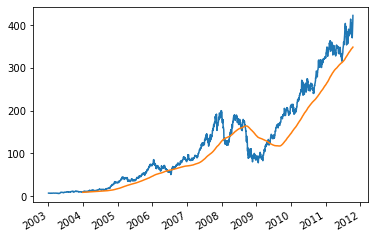

In [8]:
close_px.plot()
close_px.rolling(250).mean().plot()

# Time Series Concepts
Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

A **trend** is observed when there is an increasing or decreasing slope observed in the time series. Whereas **seasonality** is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

Another aspect to consider is the **cyclic** behaviour. It happens when the rise and fall pattern in the series does not happen in fixed calendar-based intervals. Care should be taken to not confuse ‘cyclic’ effect with ‘seasonal’ effect. So, How to diffentiate between a ‘cyclic’ vs ‘seasonal’ pattern? If the patterns are not of fixed calendar based frequencies, then it is cyclic. Because, unlike the seasonality, cyclic effects are typically influenced by the business and other socio-economic factors.


# Additive and Multiplicative Models
Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

You can do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

Note that the additive model does not vary in frequency and amplitude over time. The multiplicative model does, in this second model, the behavior acts as an increasing funnel (which may be decreasing) 


![Seasonality](https://miro.medium.com/max/564/1*LdeXlKrgNkFUjOhnO4Zzaw.jpeg)

We use multiplicative models when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. On other hand, in the additive model, the magnitude of seasonality does not change in relation to time.

The [```seasonal_decompose```](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) in ```statsmodels``` implements this conveniently.
Setting ```extrapolate_trend='freq'``` takes care of any missing values in the trend and residuals at the beginning of the series.

Let us assume that the period is 1 month, i.e. 20 trading days per month. You might want to check with other candidate parameter values too (5 trading days in a week and 253 in a year).

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [10]:
st_apl = close_px

In [11]:
result_add = seasonal_decompose(st_apl, model='additive', period=20, extrapolate_trend='freq')

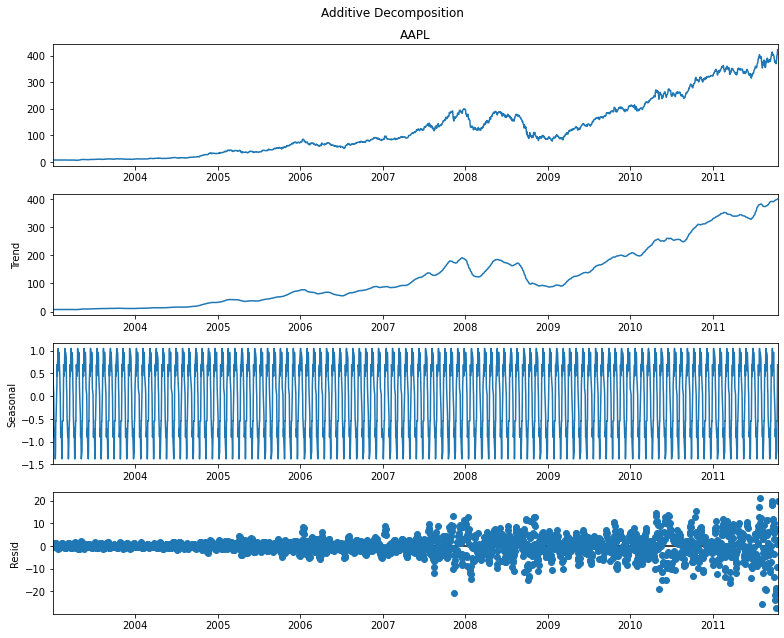

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 11,9
result_add.plot().suptitle("Additive Decomposition")
plt.tight_layout()

In [13]:
result_mul = seasonal_decompose(st_apl, model='multiplicative', period=20, extrapolate_trend='freq')

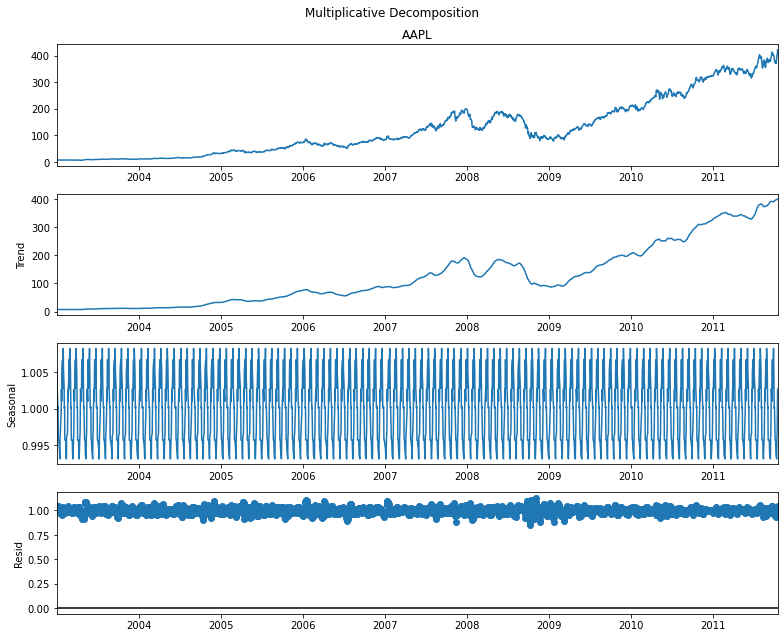

In [14]:
rcParams['figure.figsize'] = 11,9
result_mul.plot().suptitle("Multiplicative Decomposition")
plt.tight_layout()

If you look at the residuals of the additive decomposition closely, it has some pattern left over. The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

The numerical output of the trend, seasonal and residual components are stored in the result_mul output itself. Let’s extract them and put it in a dataframe.

In [16]:
df_reconsturucted = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconsturucted.columns = ['seas','trend', 'resid', 'actual_values']
df_reconsturucted.head()

,seas,trend,resid,actual_values
2003-01-02,1.005378,7.121891,1.033492,7.40
2003-01-03,1.002826,7.127416,1.042314,7.45
2003-01-06,1.000053,7.132941,1.044394,7.45
2003-01-07,1.000235,7.138466,1.040595,7.43
2003-01-08,0.995663,7.143990,1.023477,7.28


If you check, the product of seas, trend and resid columns should exactly equal to the actual_values.

# Stationary Time Series
Most of the time series models work on the assumption that data is stationary. Moreover,
contrary theories related to stationary time series are easier to implement than non-
stationary time series theories. A time series object is stationary if it has the following
properties:
+ No trend exists
+ Mean remains constant over time
+ Variance remains constant over time
+ No autocorrelation exists. Autocorrelation is the correlation between the series at current time with a lagged version of itself.

It is possible to make nearly any time series stationary by applying a suitable transformation. Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary.

Autoregressive forecasting models are essentially linear regression models that utilize the lag(s) of the series itself as predictors.We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors(lags of the series) in the forecasting models nearly independent.

# Tests to Determine if time series is stationary

1. Augmented Dickey-Fuller Test (other tests exist too, such as KPSS test, PP test)
2. Exploratory Data Analysis
    + Visual method of finding if distribution is stationary
    + Split the series into 2 or more contiguous parts and computing the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

## Augmented Dickey-Fuller Test

Null hypothesis is the time series possesses a unit root and is non-stationary. A linear stochastic process has a unit root if 1 is a root of the process's characteristic equation. Such a process is non-stationary but does not always have a trend. \[Source: [Wikipedia](https://en.wikipedia.org/wiki/Unit_root)\] So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test.

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
result = adfuller(result_mul.resid.dropna(), autolag='AIC')

In [19]:
print("ADF statistic"+str(result[0]))
print("p value"+str(result[1]))

ADF statistic-15.012588284918378
p value1.0502012362355696e-27


Result of ADF test: The null hypothesis is rejected as its probability of occurance (p-value) is extremely low.

In [20]:
result = adfuller(result_add.resid.dropna(), autolag='AIC')

In [21]:
print("ADF statistic"+str(result[0]))
print("p value"+str(result[1]))

ADF statistic-13.60299935635636
p value1.937023492060018e-25


Even in case of additive decomposition, ADF suggests to null hypothesis. However can we conclude that the series is stationary? No, as the heteroscedasticity in the residual is apparent

# Methods of Making a Time-Series Stationary
1. Applying transformations - such as log transformation
2. Estimating trend and removing it from the original series
3. Differencing
4. Decomposition

If the volume of the seasonal effect is directly proportional to the mean, then the seasonal effect is said to be multiplicative, and a logarithmic transformation is needed to make it additive again. This is because ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

If we assume our series to be additive, then it is not stationary. Let us try to make it stationary! 

First let us apply log transformation to the series.

## Applying log transformation

In [22]:
st_apl_log = np.log(st_apl)

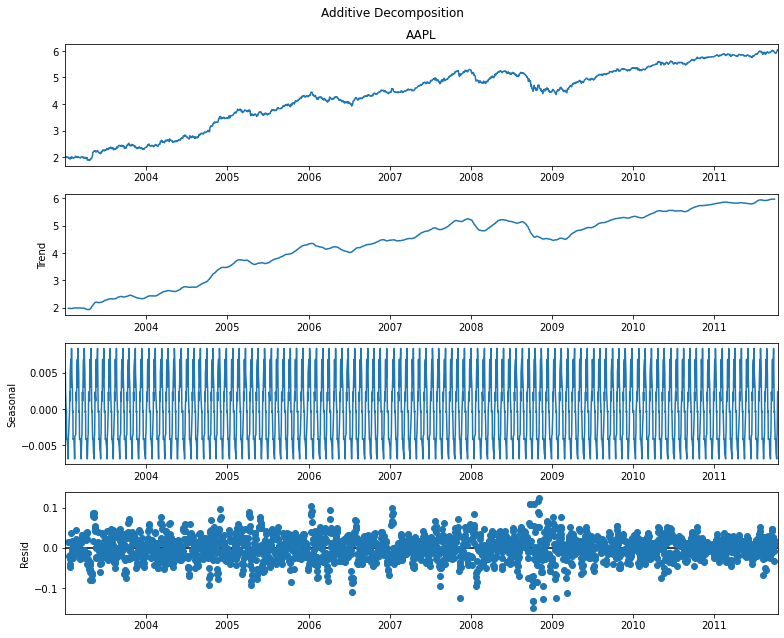

In [24]:
result_add = seasonal_decompose(st_apl_log, model="additive", period=20)

rcParams['figure.figsize'] = 11,9
result_add.plot().suptitle("Additive Decomposition")
plt.tight_layout()

In [25]:
result = adfuller(st_apl_log.dropna(), autolag='AIC')

print("ADF Statistic"+str(result[0]))
print("p value"+str(result[1]))

ADF Statistic-1.4216559465707845
p value0.5718510861798066


## Differencing
Apart from seasonal decomposition, another common approach to make the series stationary, or remove the trend line, is differencing. 

Let $y$ be the given time-series, and $y_t$ is its value at time $t$. In differencing, a trend-free time-series $z$ is computed from $y$. This depends on the nature of trendline in $y$. If it is linear, then $z$ is obtained by $$z_t = y_t-y_{t-1},$$
which is called as first order differencing. If the trendline is quadratic, then $z$ is obtained by doing differencing of differenced $y$,
$$z_t = (y_t-y_{t-1}) - (y_{t-1}-y_{t-2}),$$
which is called as second order differencing. Similarly, one can remove higher ordered trendlines as well by further differencing.

<AxesSubplot:>

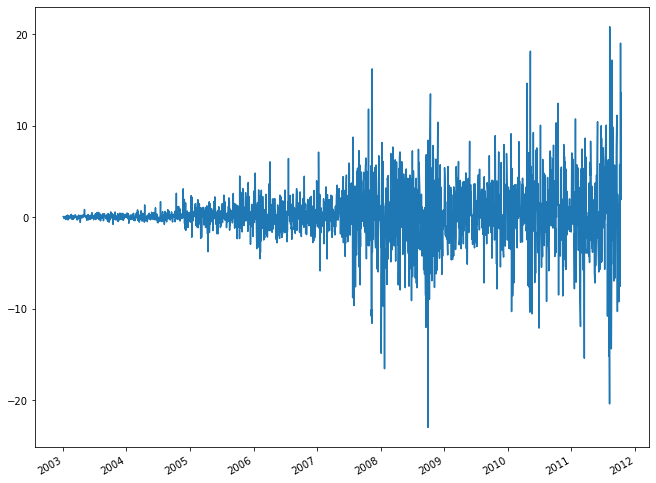

In [26]:
st_apl.diff().plot()

<AxesSubplot:>

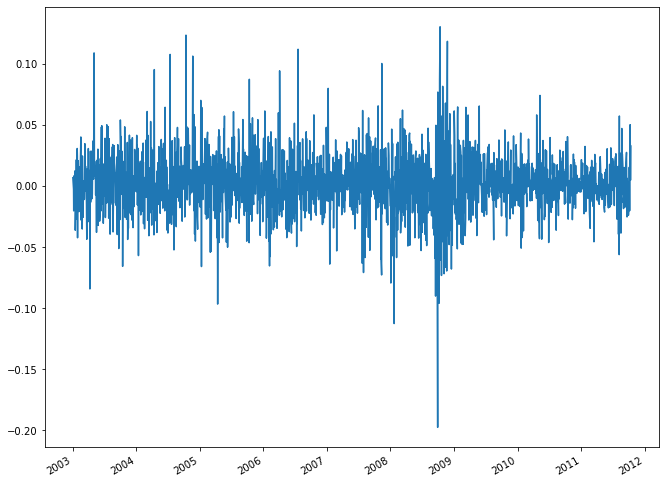

In [27]:
st_apl_log.diff().plot()

In [28]:
result = adfuller(st_apl_log.diff().dropna(), autolag='AIC')
print("ADF statistic"+str(result[0]))
print("p value"+str(str(result[1])))

ADF statistic-18.9374060122565
p value0.0


# ARIMA Model
In ARIMA, the given time-series $y$ is modelled using 3 components:
+ *Auto Regressive* (AR)
+ *Integrated* (I)
+ *Moving Average* (MA)

The AR and MA are essentially linear regression models: the target variable is the detrended (stationary) time-series $z$ obtained after differencing. The role of *Integration* (I) will become clear in a while.  
In AR, $z_t$ is modeled in terms of its `p` *lagged* values
$$z_t = c + \beta_1 z_{t-1} + \cdots + \beta_p z_{t-p} + \epsilon_t,$$
where $\epsilon_t$ is the random error at time $t$ and $c$ is the constant term of regression.  
Whereas in MA, $z_t$ modeled in terms of `q` lagged error terms:
$$z_t = c + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t.$$
And together in ARMA, $z_t$ is modeled as 
$$z_t = c + \beta_1 z_{t-1} + \cdots + \beta_p z_{t-p} + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t.$$

<font color=blue>Why are we doing linear regression on stationary time-series of $y$ instead of directly on $y$?</font>

But How do we recover $y$ from $z$? This is done in the reverse way of how we found $z$ from $y$, which is differencing. And reverse of differencing (discrete differentiation) is integration (I). You see, in case of a first order differencing, one can recover $y_t$ as 

$$
\begin{align}
y_t &= (y_t - y_{t-1}) + (y_{t-1} - y_{t-2}) + \cdots + (y_{2} - y_1) + (y_1 - y_0) + y_0 \\
    &= z_t + z_{t-1} + \cdots + z_2 + z_1 + y_0 \\
    &= \sum_{s=1}^{t} z_{s} + y_0.
\end{align}
$$

This is a discrete version of integration $y(t) = \int_{s=0}^t z(s) ds + y(0)$. Similarly, one can derive integration for `d`th order differencing as well.

So, ARIMA model is specified by the orders of its respective components `(p,d,q)`.  
But how to find the orders? You could just try some different combinations of terms and see what works best.
It can also be done by systematically by examining the correlations in the time series -- Autocorrelations and Partial Autocorrelations -- by plotting them. However, for the tutorial, we not go into understanding this method, and pick up a combination of terms and run the forecasting.

So, simply put, ‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. Let us use exponential smoothing model - ARIMA(011).

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

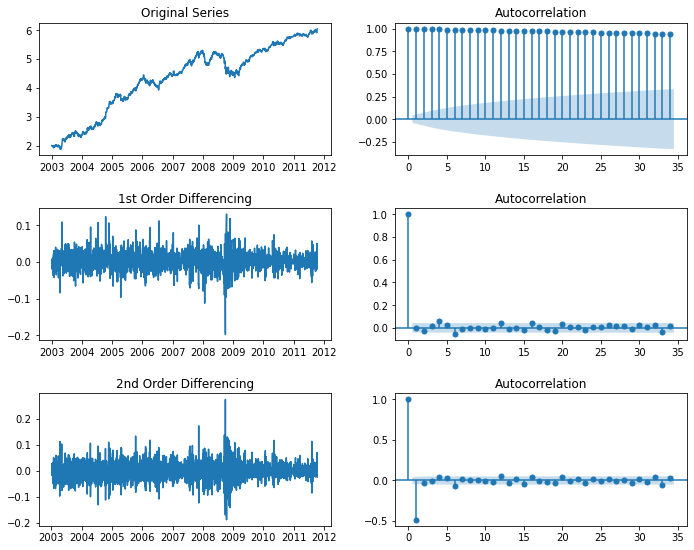

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Original Series
axes[0, 0].plot(st_apl_log); plt.title('Original')
axes[0, 0].set_title('Original Series')
plot_acf(st_apl_log, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(st_apl_log.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(st_apl_log.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(st_apl_log.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(st_apl_log.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout(pad=2.0)
plt.show()


In [31]:
from statsmodels.tsa.arima_model import ARIMA

We use the [```ARIMA```](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.html) model available in ```statsmodel```. We can use the ```fit```  function which returns [ARIMAResults](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.html#statsmodels.tsa.arima_model.ARIMAResults) class.

In [32]:
model = ARIMA(st_apl_log, order=(0,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\supar\miniconda3\envs\IT5006\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\supar\miniconda3\envs\IT5006\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                 D.AAPL   No. Observations:                 2213
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5075.747
Method:                       css-mle   S.D. of innovations              0.024
Date:                Fri, 19 Mar 2021   AIC                         -10145.493
Time:                        18:16:07   BIC                         -10128.387
Sample:                             1   HQIC                        -10139.244
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0018      0.001      3.524      0.000       0.001       0.003
ma.L1.D.AAPL    -0.0010      0.022     -0.046      0.963      -0.044       0.042
                                    Roots   

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms. We typically want a model such that the terms are significant (the p-values column) - which happens to be in our case.

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

<AxesSubplot:title={'center':'Density'}, ylabel='Density'>

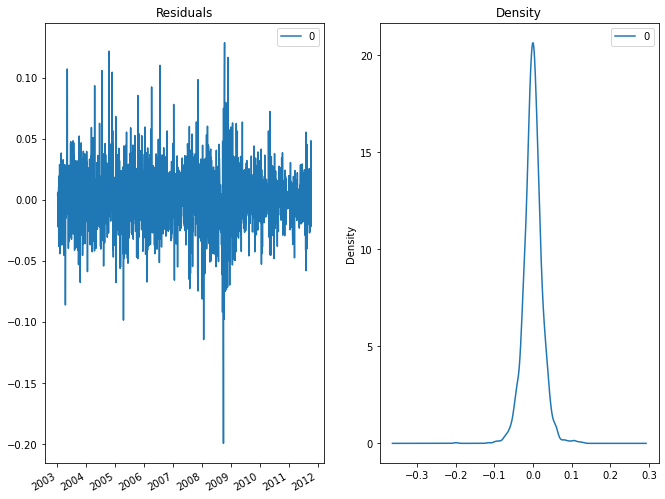

In [33]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title="Density", ax=ax[1])

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using ```plot_predict()```. When you set ```dynamic=False``` the in-sample lagged values are used for prediction. That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

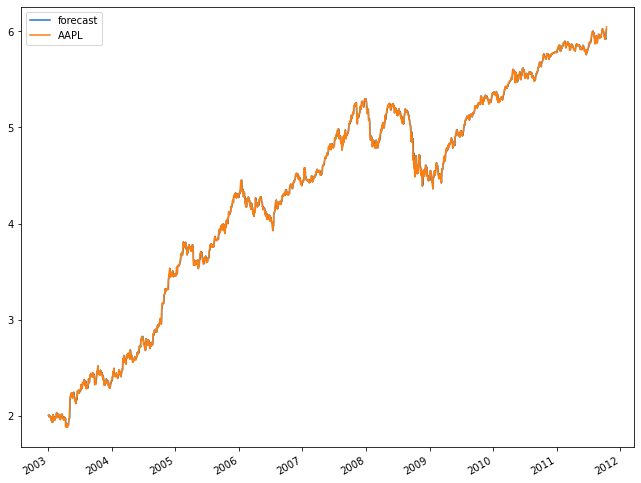

In [34]:
model_fit.plot_predict(dynamic=False)
plt.show()

### Out-of-Time cross-validation

For a real-validation, let us do a Out-of-Time cross-validation. In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

In [35]:
from statsmodels.tsa.stattools import acf

In [36]:
st_apl_log.shape

(2214,)

In [37]:
train = st_apl_log[:1660]
test = st_apl_log[1660:]

In [38]:
model = ARIMA(train, order=(0,1,1))
fitted = model.fit(disp=-1)

C:\Users\supar\miniconda3\envs\IT5006\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\supar\miniconda3\envs\IT5006\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [39]:
fc, se, conf = fitted.forecast(554, alpha=0.05)

In [40]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

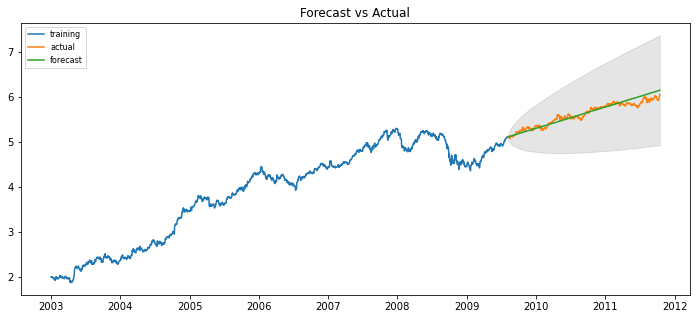

In [44]:
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the timeline.

### Metrics for evaluation

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)

Typically, if you are comparing forecasts of two different series, the MAPE and Correlation can be used.

In [42]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE - Mean absolute percentage error
    me = np.mean(forecast - actual)             # ME - mean error
    mae = np.mean(np.abs(forecast - actual))    # MAE - mean absolute error
    mpe = np.mean((forecast - actual)/actual)   # MPE - mean percentage error
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

In [43]:
forecast_accuracy(fc, test.values)

{'mape': 0.010995517254532164,
 'me': 0.018662719181142,
 'mae': 0.06255264409192368,
 'mpe': 0.0030526555777713265,
 'rmse': 0.0809023453956083,
 'corr': 0.9719492936341538}

# Practice Exercise (Optional):
1. Compute a DataFrame consisting of the yearly correlations of daily returns (computed from percent changes) with SPX using the original csv file. For this, first create a function that computes the pairwise correlation of each column with the 'SPX' column. Then compute percent change on close_px using ```pct_change``` function available in pandas.
2. Lookup the ```resample``` function in pandas. Resampling refers to the process of converting a time series from one frequency to another. Aggregating higher frequency data to lower frequency is called downsampling, while converting lower frequency to higher frequency is called upsampling. Not all resampling falls into either of these categories; for example, converting W-WED (weekly on Wednesday) to W-FRI is neither upsampling nor downsampling. ```resample``` has similar API to ```groupby``` - you group the data and then call an aggregate function. How can you resample the data to a business day frequency? 
3. What would you use for forecasting in case of multiplicative decomposition? 
4. The current forecasts are in log transformed series. Transform them back to the original series.